# COMP258 F24 Group Project 

## SETUP

In [34]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import IntegerLookup

from data_map import DATA_RAW_PATH, DATA_PATH, SKIP_ROWS, METADATA, VALUE_MAPPINGS, NUMERIC_RANGES  

In [2]:
seed = 38 # Global random seed

## DATA PREPARATION

### Load

In [3]:
# Read column names from metadata
features = METADATA["independent_variables"] 
labels = METADATA["dependent_variable"]
cat_features = [k for k in VALUE_MAPPINGS.keys()]
num_features = [f for f in features if f not in cat_features]
columns = features + [labels]
columns

['First Term Gpa',
 'Second Term Gpa',
 'First Language',
 'Funding',
 'School',
 'Fast Track',
 'Coop',
 'Residency',
 'Gender',
 'Previous Education',
 'Age Group',
 'High School Average Mark',
 'Math Score',
 'English Grade',
 'FirstYearPersistence']

In [4]:
# Load data
raw = pd.read_csv(DATA_RAW_PATH, names=columns, 
                  skiprows=SKIP_ROWS, na_values='?')
raw.head()

,First Term Gpa,Second Term Gpa,First Language,Funding,School,Fast Track,Coop,Residency,Gender,Previous Education,Age Group,High School Average Mark,Math Score,English Grade,FirstYearPersistence
0,0.000000,0.000000,1.0,2,6,2,1,1,2,1.0,1.0,59.0,16.0,7.0,1
1,2.500000,2.000000,3.0,4,6,1,2,2,2,1.0,3.0,NaN,NaN,7.0,1
2,4.250000,3.923077,1.0,1,6,2,1,1,1,2.0,3.0,92.0,41.0,9.0,1
3,3.020833,2.321429,3.0,4,6,1,2,2,2,2.0,3.0,NaN,NaN,8.0,1
4,4.275000,4.326923,1.0,2,6,1,1,1,1,2.0,3.0,97.0,NaN,9.0,1


### Explore

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1437 entries, 0 to 1436
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   First Term Gpa            1420 non-null   float64
 1   Second Term Gpa           1277 non-null   float64
 2   First Language            1326 non-null   float64
 3   Funding                   1437 non-null   int64  
 4   School                    1437 non-null   int64  
 5   Fast Track                1437 non-null   int64  
 6   Coop                      1437 non-null   int64  
 7   Residency                 1437 non-null   int64  
 8   Gender                    1437 non-null   int64  
 9   Previous Education        1433 non-null   float64
 10  Age Group                 1433 non-null   float64
 11  High School Average Mark  694 non-null    float64
 12  Math Score                975 non-null    float64
 13  English Grade             1392 non-null   float64
 14  FirstYea

In [6]:
raw.describe()  # statistics

,First Term Gpa,Second Term Gpa,First Language,Funding,School,Fast Track,Coop,Residency,Gender,Previous Education,Age Group,High School Average Mark,Math Score,English Grade,FirstYearPersistence
count,1420.000000,1277.000000,1326.000000,1437.000000,1437.0,1437.000000,1437.000000,1437.000000,1437.000000,1433.000000,1433.000000,694.000000,975.000000,1392.000000,1437.000000
mean,2.846073,2.820176,1.911011,2.926931,6.0,1.741823,1.695198,1.406402,1.774530,1.274948,2.631542,77.152738,32.557949,8.030172,0.791928
std,1.175098,1.128632,0.994892,1.257658,0.0,0.437784,0.460484,0.491332,0.419699,0.567799,1.421467,12.072760,10.709458,1.716150,0.406070
min,0.000000,0.000000,1.000000,1.000000,6.0,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,17.000000,6.000000,1.000000,0.000000
25%,2.250000,2.260000,1.000000,2.000000,6.0,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,70.000000,23.000000,7.000000,1.000000
50%,3.102632,3.027778,1.000000,2.000000,6.0,2.000000,2.000000,1.000000,2.000000,1.000000,3.000000,77.500000,32.000000,8.000000,1.000000
75%,3.739130,3.680000,3.000000,4.000000,6.0,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,85.000000,43.000000,9.000000,1.000000
max,4.500000,4.500000,3.000000,9.000000,6.0,2.000000,2.000000,2.000000,3.000000,2.000000,8.000000,108.000000,50.000000,10.000000,1.000000


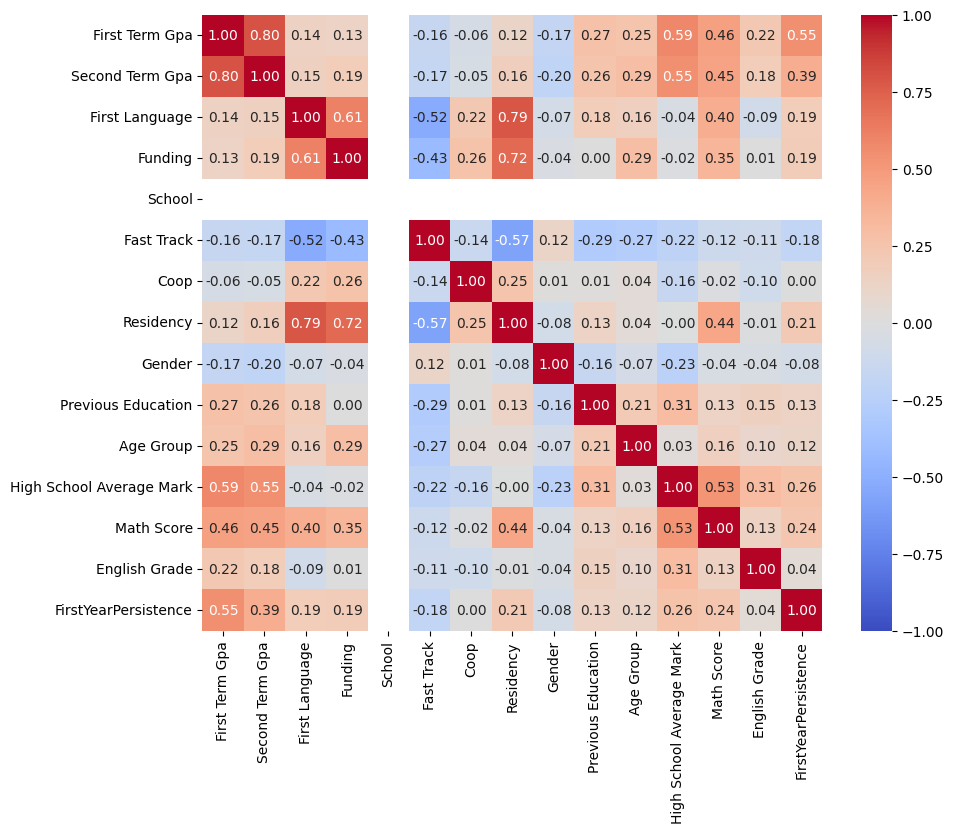

In [7]:
# Plot correlation heatmap
def corr_heat(data):
    corr = data.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
    plt.show()

corr_heat(raw)

### Clean

#### Dropna

In [8]:
# Drop features having small nan, weak correlation and categorical
dropped = raw.dropna(
    subset=["Previous Education", "Age Group", 'First Language', 'English Grade'])
dropped.count()

First Term Gpa              1268
Second Term Gpa             1141
First Language              1284
Funding                     1284
School                      1284
Fast Track                  1284
Coop                        1284
Residency                   1284
Gender                      1284
Previous Education          1284
Age Group                   1284
High School Average Mark     665
Math Score                   875
English Grade               1284
FirstYearPersistence        1284
dtype: int64

#### Imputation

In [9]:
# IterativeImputer for missing numeric values
imputer = IterativeImputer(
    estimator=RandomForestRegressor(), 
    max_iter=10,
    n_nearest_features=6, # speed up and prevent overfitting
    imputation_order="ascending", # start from fewer missing features
    tol=1,  # tolerance of the stopping condition.
    random_state=seed)

In [10]:
# Perform imputation
imputed = imputer.fit_transform(dropped)

/root/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### Save

In [14]:
# save data
imputed_df = pd.DataFrame(imputed, columns=columns)
imputed_df.to_csv(DATA_PATH, index=False)

In [15]:
# reload
data = pd.read_csv(DATA_PATH)
data.head()

,First Term Gpa,Second Term Gpa,First Language,Funding,School,Fast Track,Coop,Residency,Gender,Previous Education,Age Group,High School Average Mark,Math Score,English Grade,FirstYearPersistence
0,0.000000,0.000000,1.0,2.0,6.0,2.0,1.0,1.0,2.0,1.0,1.0,59.00,16.00,7.0,1.0
1,2.500000,2.000000,3.0,4.0,6.0,1.0,2.0,2.0,2.0,1.0,3.0,75.29,31.84,7.0,1.0
2,4.250000,3.923077,1.0,1.0,6.0,2.0,1.0,1.0,1.0,2.0,3.0,92.00,41.00,9.0,1.0
3,3.020833,2.321429,3.0,4.0,6.0,1.0,2.0,2.0,2.0,2.0,3.0,75.04,34.56,8.0,1.0
4,4.275000,4.326923,1.0,2.0,6.0,1.0,1.0,1.0,1.0,2.0,3.0,97.00,39.05,9.0,1.0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   First Term Gpa            1284 non-null   float64
 1   Second Term Gpa           1284 non-null   float64
 2   First Language            1284 non-null   float64
 3   Funding                   1284 non-null   float64
 4   School                    1284 non-null   float64
 5   Fast Track                1284 non-null   float64
 6   Coop                      1284 non-null   float64
 7   Residency                 1284 non-null   float64
 8   Gender                    1284 non-null   float64
 9   Previous Education        1284 non-null   float64
 10  Age Group                 1284 non-null   float64
 11  High School Average Mark  1284 non-null   float64
 12  Math Score                1284 non-null   float64
 13  English Grade             1284 non-null   float64
 14  FirstYea

## INPUT PIPELINE

### Prepare

In [41]:
# Column defualts
column_defaults = [
    tf.constant([0.0], dtype=tf.float32),  # First Term Gpa (numeric)
    tf.constant([0.0], dtype=tf.float32),  # Second Term Gpa (numeric)
    tf.constant([0], dtype=tf.int32),      # First Language (categorical as int)
    tf.constant([0], dtype=tf.int32),      # Funding (categorical as int)
    tf.constant([0], dtype=tf.int32),      # School (categorical as int)
    tf.constant([0], dtype=tf.int32),      # Fast Track (categorical as int)
    tf.constant([0], dtype=tf.int32),      # Coop (categorical as int)
    tf.constant([0], dtype=tf.int32),      # Residency (categorical as int)
    tf.constant([0], dtype=tf.int32),      # Gender (categorical as int)
    tf.constant([0], dtype=tf.int32),      # Previous Education (categorical as int)
    tf.constant([0], dtype=tf.int32),      # Age Group (categorical as int)
    tf.constant([0.0], dtype=tf.float32),  # High School Average Mark (numeric)
    tf.constant([0.0], dtype=tf.float32),  # Math Score (numeric)
    tf.constant([0], dtype=tf.int32),      # English Grade (categorical as int)
    tf.constant([0], dtype=tf.int32),      # FirstYearPersistence (label as int)
]

In [25]:
# Column indices for numeric and categorical features
num_inx = [columns.index(col) for col in num_features]
cat_inx = [columns.index(col) for col in cat_features]
num_inx, cat_inx

([0, 1, 11, 12], [2, 3, 4, 5, 6, 7, 8, 9, 10, 13])

In [30]:
# Get mean and std for numeric data
num_mean = data[num_features].mean().astype(np.float32)
num_std = data[num_features].std().astype(np.float32)
print(num_mean)
print(num_std)

First Term Gpa               2.818987
Second Term Gpa              2.634676
High School Average Mark    79.241257
Math Score                  33.249245
dtype: float32
First Term Gpa               1.171467
Second Term Gpa              1.207105
High School Average Mark    10.583131
Math Score                   9.850549
dtype: float32


In [45]:
# Integer Lookup list
lookups = [
    IntegerLookup(vocabulary=list(VALUE_MAPPINGS[col].keys()), name=col)
    for col in cat_features
]

lookups

[<IntegerLookup name=First Language, built=False>,
 <IntegerLookup name=Funding, built=False>,
 <IntegerLookup name=School, built=False>,
 <IntegerLookup name=Fast Track, built=False>,
 <IntegerLookup name=Coop, built=False>,
 <IntegerLookup name=Residency, built=False>,
 <IntegerLookup name=Gender, built=False>,
 <IntegerLookup name=Previous Education, built=False>,
 <IntegerLookup name=Age Group, built=False>,
 <IntegerLookup name=English Grade, built=False>]

### Pipeline 